# **Anomaly Detection in Time Series Data**

This will be a **short notebook exploring Anomaly Detection**. I will, initially, use just one algorithm (**Isolation Forest**), but with the view to expand this notebook over time.

The Isolation Forest ‘isolates’ observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.

Since recursive partitioning can be represented by a tree structure, the number of splittings required to isolate a sample is equivalent to the path length from the root node to the terminating node.

This path length, averaged over a forest of such random trees, is a measure of normality and our decision function.

Random partitioning produces noticeably shorter paths for anomalies. Hence, when a forest of random trees collectively produce shorter path lengths for particular samples, they are highly likely to be anomalies.

## **Different Approaches to Time Series Anomaly Detection**

Check out this notebook I put together to showcase the **STUMPY** Matrix Profiling library and how it can be used for anomaly detection:

https://www.kaggle.com/code/joshuaswords/anomaly-detection-with-stumpy-matrix-profiling

In [162]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import torch.nn.functional as F

# Preprocessing

Explanation
Directory Path: The data_dir variable should be set to the path of the main directory containing your annotated data directories.

Reading Files: We loop through each activity directory within the main directory and then loop through each file in these directories. For each file, we extract metadata (activity type, sensor type, participant ID, and trial number) from the filename.

Reading Data: Each CSV file is read into a DataFrame using pd.read_csv. No header is present in the data files (header=None).

Combining Data: Metadata columns are added to each DataFrame, and these DataFrames are appended to a list. All DataFrames in the list are then concatenated into a single DataFrame using pd.concat.

Optional Saving: The combined DataFrame is saved to a new CSV file named combined_mobiact_dataset.csv.

In [2]:
import os
import pandas as pd
import glob
import random

def load_and_combine_data(data_folder, sample_percentage=100):
    # Recursively search for all activity folders
    activity_folders = glob.glob(os.path.join(data_folder, '*'))
    
    # Create an empty list to store the data
    all_data = []

    # Iterate through each activity folder
    for activity_folder in activity_folders:
        print(f"Processing activity folder: {activity_folder}")
        
        # Search for all CSV files within the current activity folder
        data_files = glob.glob(os.path.join(activity_folder, '*.csv'))
        
        # Shuffle the list of data files to ensure random sampling
        random.shuffle(data_files)
        
        # Calculate the number of files to load based on the sample percentage
        num_files_to_load = int(len(data_files) * sample_percentage / 100)
        
        # Iterate through each CSV file in the current activity folder
        for i, file in enumerate(data_files):
            if i < num_files_to_load:
                file_path = os.path.abspath(file)
                data = pd.read_csv(file_path)
                
                # Extract metadata from the filename
                parts = os.path.basename(file).split('_')
                activity_type = parts[0]
                sensor_type = parts[1]
                participant_id = parts[2]
                trial_no = parts[3].split('.')[0]
                
                # Add metadata columns to the DataFrame
                data['Activity Type'] = activity_type
                data['Sensor Type'] = sensor_type
                data['Participant ID'] = participant_id
                data['Trial No'] = trial_no
                
                all_data.append(data)
                #### print(f"Loaded {i+1}/{num_files_to_load} files for this activity.")
    
    # Concatenate all the loaded data into a single DataFrame
    combined_data = pd.concat(all_data, ignore_index=True)
    
    return combined_data

# Define the path to the annotated data folder
data_folder = '/kaggle/input/mobiact-dataset-v2/MobiAct_Dataset_v2.0/Annotated Data'
sample_percentage = 10  # Load only 30% of the dataset

# Load and combine data from all activity folders with sampling
combined_data = load_and_combine_data(data_folder, sample_percentage)

# Export combined data to a CSV file
output_file = 'combined_mobiact_dataset.csv'
combined_data.to_csv(output_file, index=False)
print(f"Combined data exported to {output_file}")

Processing activity folder: /kaggle/input/mobiact-dataset-v2/MobiAct_Dataset_v2.0/Annotated Data/FOL
Processing activity folder: /kaggle/input/mobiact-dataset-v2/MobiAct_Dataset_v2.0/Annotated Data/CSO
Processing activity folder: /kaggle/input/mobiact-dataset-v2/MobiAct_Dataset_v2.0/Annotated Data/STU
Processing activity folder: /kaggle/input/mobiact-dataset-v2/MobiAct_Dataset_v2.0/Annotated Data/SDL
Processing activity folder: /kaggle/input/mobiact-dataset-v2/MobiAct_Dataset_v2.0/Annotated Data/SLH
Processing activity folder: /kaggle/input/mobiact-dataset-v2/MobiAct_Dataset_v2.0/Annotated Data/SCH
Processing activity folder: /kaggle/input/mobiact-dataset-v2/MobiAct_Dataset_v2.0/Annotated Data/STN
Processing activity folder: /kaggle/input/mobiact-dataset-v2/MobiAct_Dataset_v2.0/Annotated Data/SBE
Processing activity folder: /kaggle/input/mobiact-dataset-v2/MobiAct_Dataset_v2.0/Annotated Data/WAL
Processing activity folder: /kaggle/input/mobiact-dataset-v2/MobiAct_Dataset_v2.0/Annotated

## 1. Load the Combined Dataset
We'll load the dataset using pandas.

In [3]:
import pandas as pd

# Load the combined dataset
file_path = '/kaggle/working/combined_mobiact_dataset.csv'
df = pd.read_csv(file_path)

# Display the first few rows of the dataframe
df.head()

,timestamp,rel_time,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,azimuth,pitch,roll,label,Activity Type,Sensor Type,Participant ID,Trial No
0,13673339058000,0.000000,1.998578,9.595336,-1.522535,-0.023518,0.046120,0.025962,171.01372,-34.397167,-29.037931,STD,FOL,37,1,annotated
1,13673345763000,0.006705,1.992820,9.593097,-1.536610,-0.013439,0.041844,-0.000916,171.11044,-34.687656,-28.826971,STD,FOL,37,1,annotated
2,13673349052000,0.009994,1.989995,9.591998,-1.543514,-0.023213,0.037874,0.002138,171.20601,-34.971640,-28.608639,STD,FOL,37,1,annotated
3,13673354039000,0.014981,1.985713,9.590333,-1.553983,-0.025045,0.045204,0.003360,171.31345,-35.249390,-28.397230,STD,FOL,37,1,annotated
4,13673359072000,0.020014,1.981391,9.588652,-1.564548,-0.033903,0.044899,-0.009468,171.43219,-35.515972,-28.185482,STD,FOL,37,1,annotated


In [26]:
# Assuming 'Type Activity' is the column containing fall types

# Create a list of fall types
fall_types = ['FOL', 'FKL', 'BSC', 'SDL']

# Create a new column 'Fall' to indicate true/false for falls
df['Fall'] = df['Activity Type'].isin(fall_types)

# Convert 'Fall' column to integer (0 for false, 1 for true)
df['Fall'] = df['Fall'].astype(int)

# Print the updated DataFrame
print(df)

              timestamp  rel_time     acc_x     acc_y     acc_z    gyro_x  \
0        13673339058000  0.000000  1.998578  9.595336 -1.522535 -0.023518   
1        13673345763000  0.006705  1.992820  9.593097 -1.536610 -0.013439   
2        13673349052000  0.009994  1.989995  9.591998 -1.543514 -0.023213   
3        13673354039000  0.014981  1.985713  9.590333 -1.553983 -0.025045   
4        13673359072000  0.020014  1.981391  9.588652 -1.564548 -0.033903   
...                 ...       ...       ...       ...       ...       ...   
1517866   1283115777000  5.674896  1.266122 -9.676372 -0.030883 -0.015882   
1517867   1283120751000  5.679870  1.261379 -9.678743 -0.014285 -0.023824   
1517868   1283125795000  5.684914  1.256570 -9.681148  0.002546 -0.015882   
1517869   1283130775000  5.689894  1.249035 -9.679388 -0.009768 -0.014661   
1517870   1283135775000  5.694894  1.239415 -9.674579 -0.043435 -0.016799   

           gyro_y    gyro_z    azimuth      pitch       roll label  \
0    

## 2. Check the Structure and Summary Statistics
We'll examine the structure and summary statistics to understand the dataset better.

In [4]:
# Display basic information about the dataset
df.info()

# Display summary statistics
df.describe()

# Display the unique activities in the dataset
df['Activity Type'].unique()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1517871 entries, 0 to 1517870
Data columns (total 16 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   timestamp       1517871 non-null  int64  
 1   rel_time        1517871 non-null  float64
 2   acc_x           1517871 non-null  float64
 3   acc_y           1517871 non-null  float64
 4   acc_z           1517871 non-null  float64
 5   gyro_x          1517871 non-null  float64
 6   gyro_y          1517871 non-null  float64
 7   gyro_z          1517871 non-null  float64
 8   azimuth         1517871 non-null  float64
 9   pitch           1517871 non-null  float64
 10  roll            1517871 non-null  float64
 11  label           1517871 non-null  object 
 12  Activity Type   1517871 non-null  object 
 13  Sensor Type     1517871 non-null  int64  
 14  Participant ID  1517871 non-null  int64  
 15  Trial No        1517871 non-null  object 
dtypes: float64(10), int64(3), object(3)


array(['FOL', 'CSO', 'STU', 'SDL', 'SLH', 'SCH', 'STN', 'SBE', 'WAL',
       'CSI', 'SIT', 'SBW', 'FKL', 'JUM', 'SRH', 'BSC', 'STD', 'JOG',
       'SLW', 'CHU'], dtype=object)

## 3. Visualize the Distribution of Activities
We'll create a bar plot to visualize the distribution of different activities in the dataset.

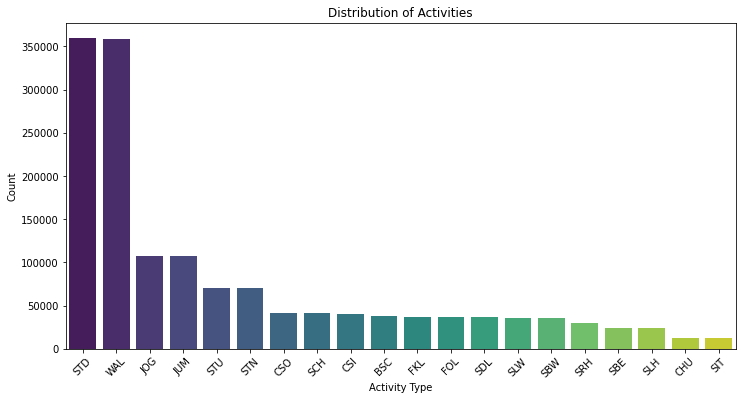

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the occurrences of each activity type
activity_counts = df['Activity Type'].value_counts()

# Create a bar plot of the activity distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=activity_counts.index, y=activity_counts.values, palette='viridis')
plt.title('Distribution of Activities')
plt.xlabel('Activity Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


## 4. Evaluate the Quality of the Dataset
We'll check for missing values and inconsistencies to assess the dataset's quality.

In [6]:
# Check for missing values
missing_values = df.isnull().sum()

# Display columns with missing values
missing_values[missing_values > 0]

# Check for duplicates
duplicate_rows = df.duplicated().sum()

# Display the number of duplicate rows
duplicate_rows

# Check the balance of activities
activity_balance = df['Activity Type'].value_counts(normalize=True) * 100

# Display the balance of activities
activity_balance

STD    23.688377
WAL    23.656424
JOG     7.041771
JUM     7.038213
STU     4.613040
STN     4.601643
CSO     2.721443
SCH     2.715053
CSI     2.640936
BSC     2.513586
FKL     2.443422
FOL     2.441512
SDL     2.430575
SLW     2.364496
SBW     2.359621
SRH     1.969667
SBE     1.577077
SLH     1.573652
CHU     0.823851
SIT     0.785640
Name: Activity Type, dtype: float64

## 5. Visualize Sensor Data for Each Activity
We'll plot sensor data for a few activities to get an idea of the data quality and patterns.

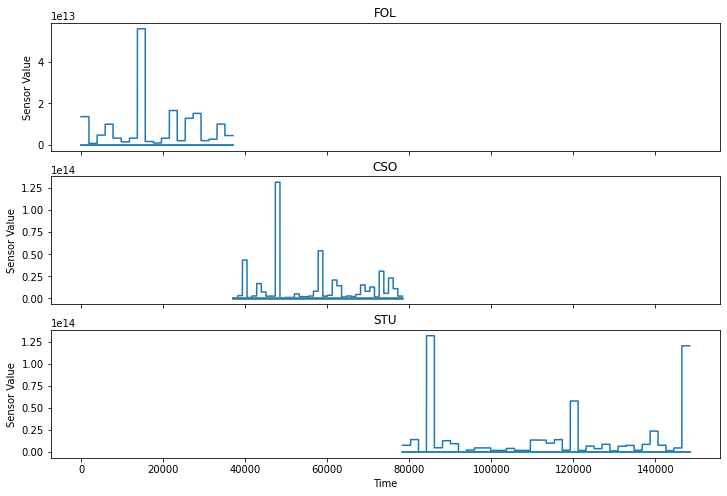

In [7]:
# Sample a few activities to plot
sample_activities = df['Activity Type'].unique()[:3]

# Plot sensor data for each sampled activity
fig, axes = plt.subplots(len(sample_activities), 1, figsize=(12, 8), sharex=True)

for i, activity in enumerate(sample_activities):
    activity_data = df[df['Activity Type'] == activity].iloc[:, :-4]  # Exclude metadata columns
    activity_data.plot(ax=axes[i], title=activity, legend=False)
    axes[i].set_ylabel('Sensor Value')

plt.xlabel('Time')
plt.show()

It will be good to do some **Feauture Engineering** later to extract as much information as we can from these existing features.

**Housekeeping**

Checking for blank values, checking Data Types etc.

In [35]:
def overview(df: pd.DataFrame, timestamp_col: str = None) -> None:
    print('Null Count:\n', df.isnull().sum(),'\n')
    print('Data Types:\n', df.dtypes)
    
    if timestamp_col is not None:
        print('\nDate Range:\n\nStart:\t',df[timestamp_col].min())
        print('End:\t',df[timestamp_col].max())
        print('Days:\t',(df[timestamp_col].max() - df[timestamp_col].min()))

In [144]:
overview(df, timestamp_col='timestamp')

Null Count:
 timestamp         0
rel_time          0
acc_x             0
acc_y             0
acc_z             0
gyro_x            0
gyro_y            0
gyro_z            0
azimuth           0
pitch             0
roll              0
Participant ID    0
Fall              0
dtype: int64 

Data Types:
 timestamp           int64
rel_time          float64
acc_x             float64
acc_y             float64
acc_z             float64
gyro_x            float64
gyro_y            float64
gyro_z            float64
azimuth           float64
pitch             float64
roll              float64
Participant ID      int64
Fall                int64
dtype: object

Date Range:

Start:	 58106033000
End:	 131899874208000
Days:	 131841768175000


### Test plot

        timestamp  rel_time     acc_x     acc_y     acc_z    gyro_x    gyro_y  \
0  13673339058000  0.000000  1.998578  9.595336 -1.522535 -0.023518  0.046120   
1  13673345763000  0.006705  1.992820  9.593097 -1.536610 -0.013439  0.041844   
2  13673349052000  0.009994  1.989995  9.591998 -1.543514 -0.023213  0.037874   
3  13673354039000  0.014981  1.985713  9.590333 -1.553983 -0.025045  0.045204   
4  13673359072000  0.020014  1.981391  9.588652 -1.564548 -0.033903  0.044899   

     gyro_z    azimuth      pitch       roll label Activity Type  Sensor Type  \
0  0.025962  171.01372 -34.397167 -29.037931   STD           FOL           37   
1 -0.000916  171.11044 -34.687656 -28.826971   STD           FOL           37   
2  0.002138  171.20601 -34.971640 -28.608639   STD           FOL           37   
3  0.003360  171.31345 -35.249390 -28.397230   STD           FOL           37   
4 -0.009468  171.43219 -35.515972 -28.185482   STD           FOL           37   

   Participant ID   Trial 

KeyboardInterrupt: 

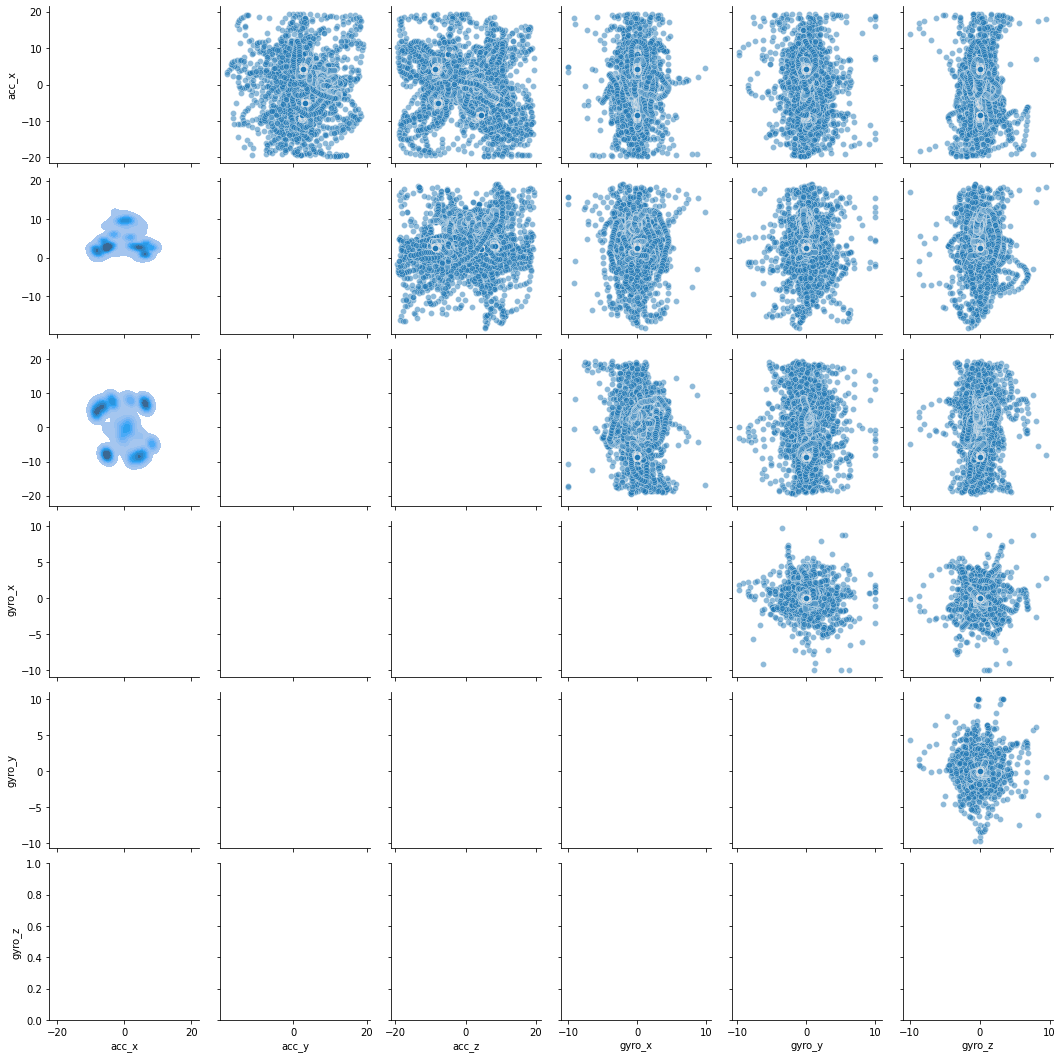

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you have a DataFrame named 'df' with fall data

# Extract fall data based on fall types
fall_types = ['FOL', 'FKL', 'BSC', 'SDL']
fall_data = df[df['Activity Type'].isin(fall_types)]

print(fall_data.head())
# Create a pair plot for each fall type
for fall_type in fall_types:
    fall_type_data = fall_data[fall_data['Activity Type'] == fall_type]
    
    # Select relevant features for plotting
    features = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']
    
    # Create a pair plot
    g = sns.PairGrid(fall_type_data[features], diag_sharey=False)
    g.map_upper(sns.scatterplot, alpha=0.5)
    g.map_lower(sns.kdeplot, fill=True)
    g.map_diag(sns.histplot)
    
    # Add a title to the plot
    g.fig.suptitle(f"Pair Plot for Fall Type: {fall_type}")
    
    # Show the plot
    plt.show()

# Train Models

### cuda

In [16]:
import torch
import torch.cuda

# Check if CUDA is available
use_cuda = torch.cuda.is_available()

# Set the device to use
device = torch.device("cuda" if use_cuda else "cpu")

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

### LSTM

In [192]:

class MHSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(MHSelfAttention, self).__init__()

        # initialize MHSelfAttention
        self.num_heads = num_heads
        self.embed_dim = embed_dim
        self.head_dim = embed_dim // num_heads
        assert self.head_dim * num_heads == embed_dim, "Embedding dimension must be divisible by number of heads"

        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.out = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        batch_size = x.size(0)

        # Linear projections for Query, Key and value
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)

        # Split into heads
        Q = Q.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)

        # Scaled dot-product attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float32))
        attn = F.softmax(scores, dim=-1)
        context = torch.matmul(attn, V)

        # Concatenate heads
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.embed_dim)

        return self.out(context)
    
### -------------- ###

class LSTM_SelfAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout,num_heads, fc_layers, embedding_dim):
        super(LSTM_SelfAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.num_heads = num_heads
         # Define layers
        self.self_attn = MHSelfAttention(input_dim, num_heads)
        self.fc = nn.Linear(input_dim, output_dim)
        self.fc_layers = fc_layers
        
         # Embedding layer
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        
        self.fc_layers = nn.ModuleList()
        for in_size, out_size in zip(fc_layers[:-1], fc_layers[1:]):
            self.fc_layers.append(nn.Linear(in_size, out_size))
            self.fc_layers.append(nn.ReLU())
            
    def forward(self, x):
        x = self.embedding(x)
         # Pass through self-attention
        x = self.self_attn(x)
        
        for layer in self.fc_layers:
            x = layer(x)

        # Pass through fully connected layer
        x = self.fc(x)
        return x



**drop columns**

In [125]:
df = df.drop('label', axis=1) # as we already encoded the labels with fall (boolean)
df = df.drop('Activity Type', axis=1) # as we already encoded the labels with fall (boolean)
df = df.drop('Trial No', axis=1) # as we already encoded the labels with fall (boolean)
df = df.drop('Sensor Type', axis=1) # as we already encoded the labels with fall (boolean)

KeyError: "['label'] not found in axis"

### Prepare data

In [164]:
import torch
import pandas as pd

# Convert non-numeric columns to numeric
df = df.apply(pd.to_numeric, errors='coerce')

# Separate features (X) and target (y)
X = torch.from_numpy(df.drop('Fall', axis=1).values)
y = torch.from_numpy(df['Fall'].values)

print(X)
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.float)
X_test = torch.tensor(X_test, dtype=torch.float)
y_test = torch.tensor(y_test, dtype=torch.float)


# Create DataLoaders
batch_size = 64
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

tensor([[ 1.3673e+13,  0.0000e+00,  1.9986e+00,  ..., -3.4397e+01,
         -2.9038e+01,  1.0000e+00],
        [ 1.3673e+13,  6.7050e-03,  1.9928e+00,  ..., -3.4688e+01,
         -2.8827e+01,  1.0000e+00],
        [ 1.3673e+13,  9.9940e-03,  1.9900e+00,  ..., -3.4972e+01,
         -2.8609e+01,  1.0000e+00],
        ...,
        [ 1.2831e+12,  5.6849e+00,  1.2566e+00,  ...,  9.5578e+01,
          5.5301e+00,  2.0000e+00],
        [ 1.2831e+12,  5.6899e+00,  1.2490e+00,  ...,  9.5575e+01,
          5.5282e+00,  2.0000e+00],
        [ 1.2831e+12,  5.6949e+00,  1.2394e+00,  ...,  9.5574e+01,
          5.5275e+00,  2.0000e+00]], dtype=torch.float64)


### Hyperparameters

In [188]:
input_dim = X_train.shape[1]  # Number of input features
hidden_dim = 8  # Number of hidden units in LSTM
output_dim = 1  # Number of output classes
num_layers = 4  # Number of LSTM layers
dropout = 0.2  # Dropout probability
fc_layers = [64,32,16,8]
learning_rate = 0.001
num_heads = 6 # self_attention
embedding_dim = 64  # You can adjust this dimension as needed
num_epochs = 30  # Number of training epochs

In [193]:
model = LSTM_SelfAttention(input_dim, hidden_dim, output_dim, num_layers, dropout,num_heads,fc_layers,embedding_dim = embedding_dim)

criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for batch, (X_batch, y_batch) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}")
    model.eval()
    total_accuracy = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            y_pred = model(X_batch)
            y_pred_binary = torch.round(torch.sigmoid(y_pred))
            accuracy = torch.sum(y_pred_binary == y_batch).item() / len(y_batch)
            total_accuracy += accuracy
        avg_accuracy = total_accuracy / len(test_loader)
        print(f"Test Accuracy: {avg_accuracy:.4f}")

RuntimeError: Expected tensor for argument #1 'indices' to have scalar type Long; but got torch.FloatTensor instead (while checking arguments for embedding)